## Testing Playground

In [1]:
import os
print(os.getcwd())
os.chdir("..")
# os.chdir("dit-editor")
print(os.getcwd())
from data.benchmark_data import gather_images

%load_ext autoreload
%autoreload 2

/mnt/dlabscratch1/anmari/dit-editor/notebooks
/mnt/dlabscratch1/anmari/dit-editor


## Load all benchmark samples along with results we have

In [2]:
# load all benchmark images (around 300)
os_path = "data/"
all_images = gather_images(os_path)

Missing images in data/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style: fg_mask
Skipping data/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style: Not all images are present in data/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style
Missing images in data/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic: fg_mask
Skipping data/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic: Not all images are present in data/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic
Loaded 4 images in data/


/mnt/dlabscratch1/anmari/dit-editor/data/benchmark_data.py:214: UserWarning: Missing 2 images in data/
  warnings.warn(f"Missing {missing_image_counter} images in {image_dir}")


Real-Real
a professional photograph of an ostrich in a garden, ultra realistic


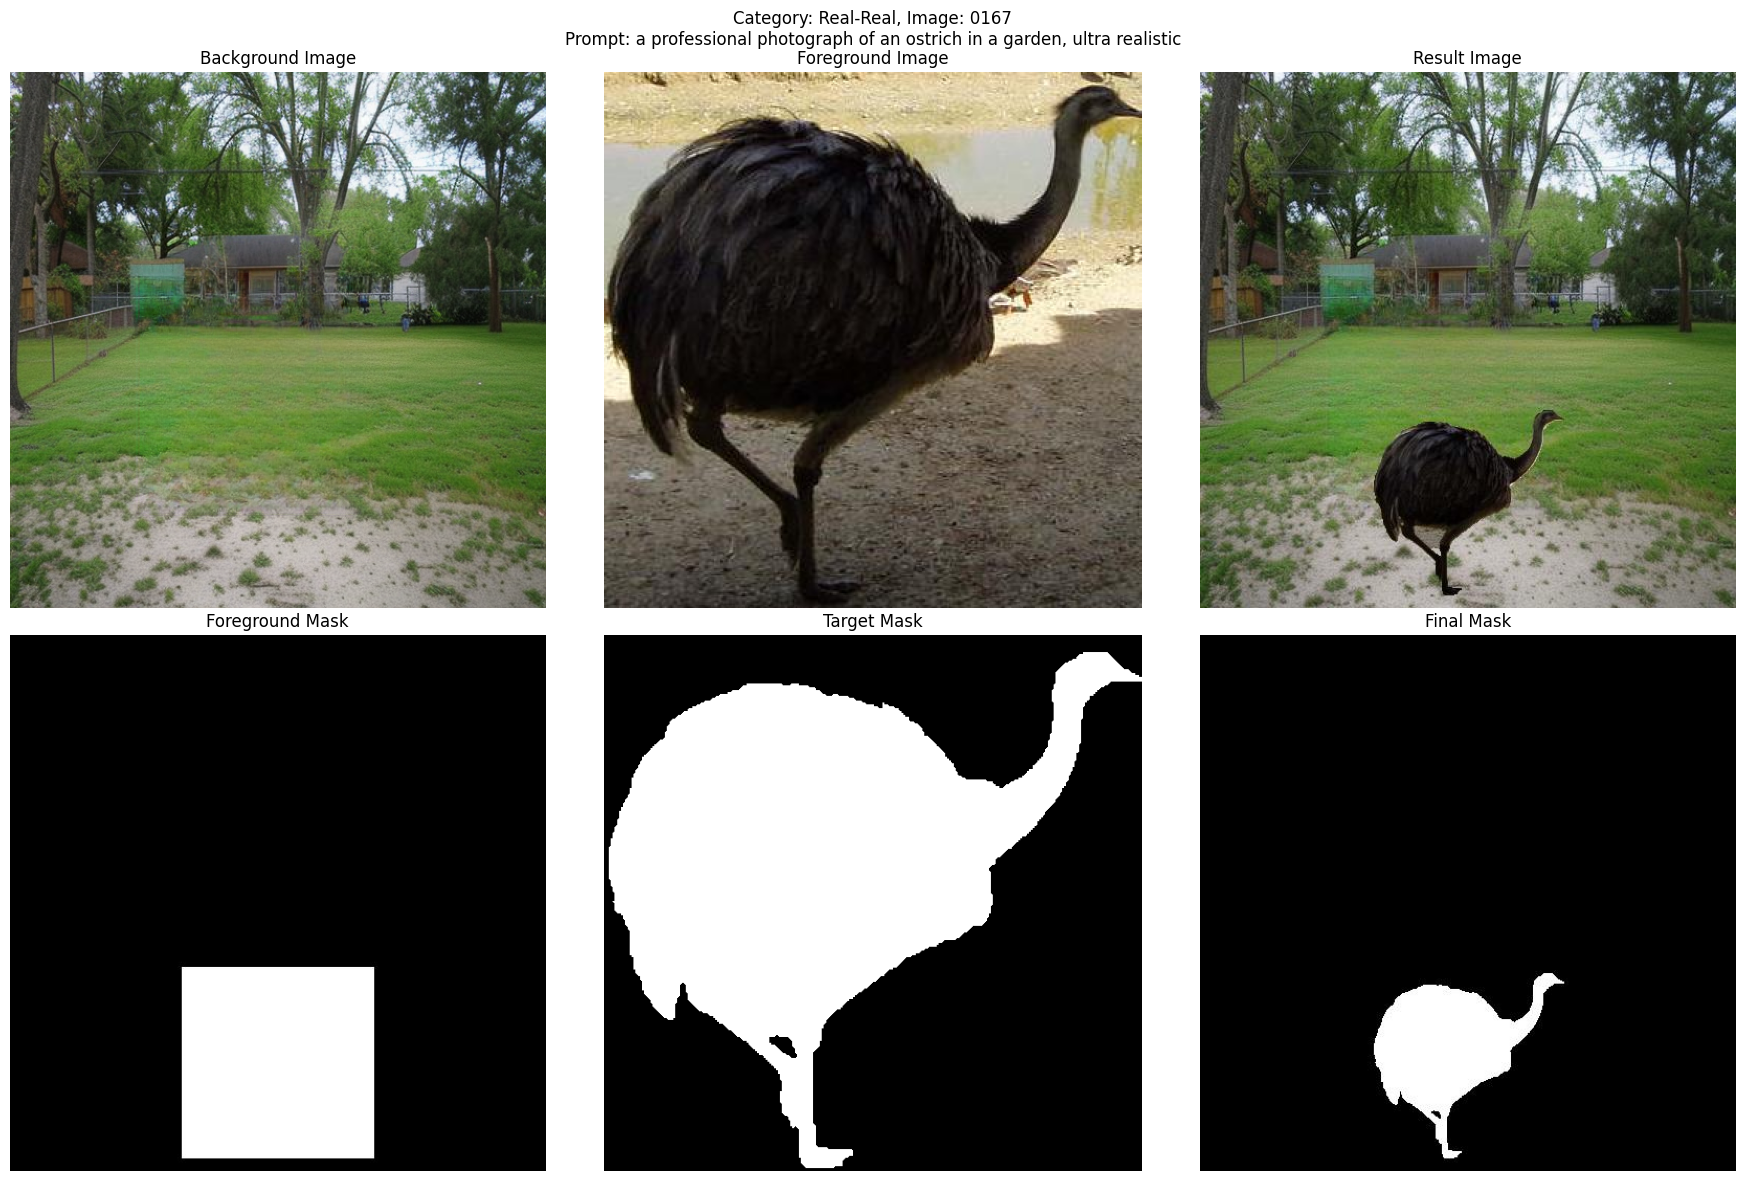

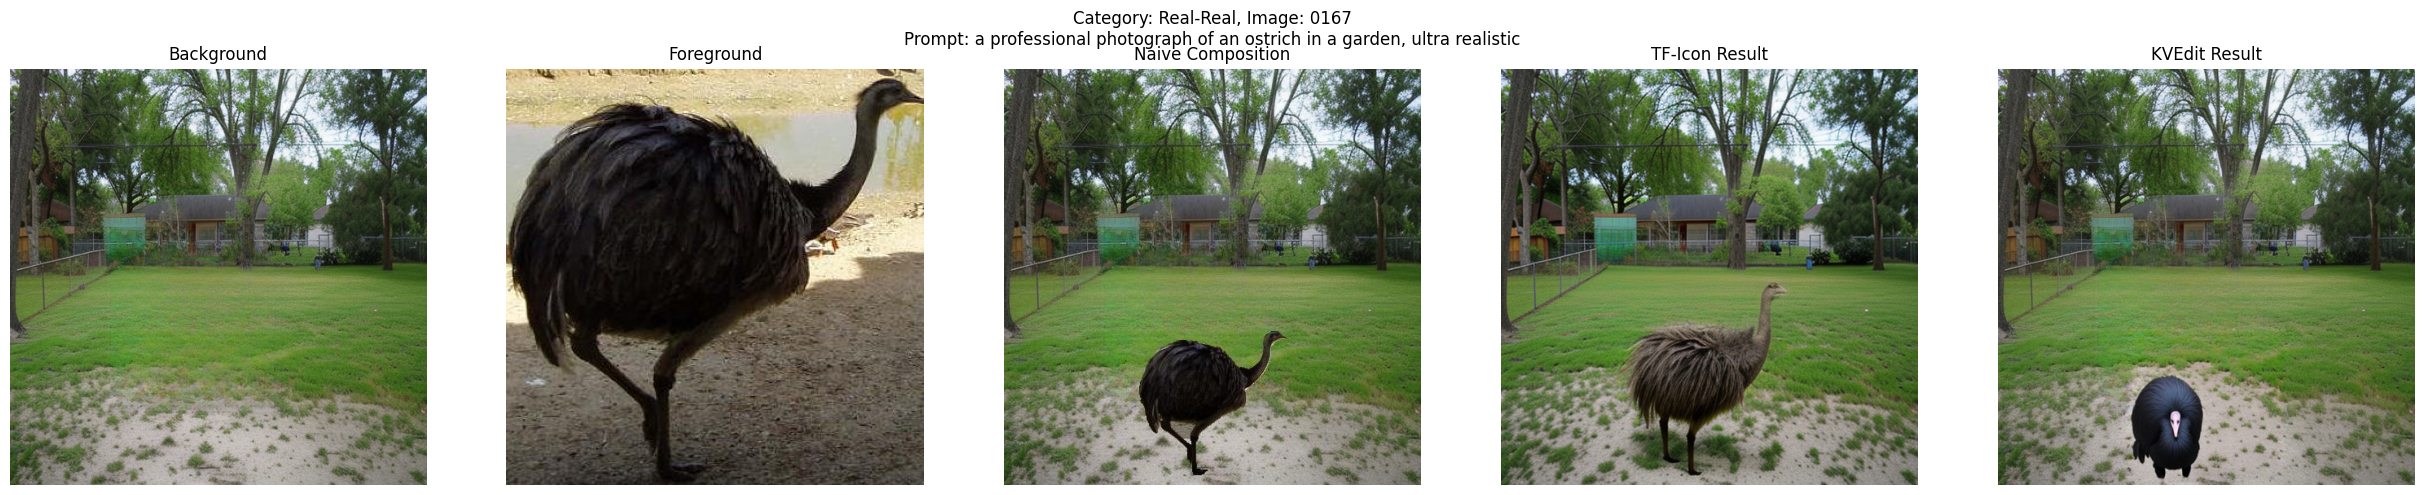

In [9]:
example = all_images[200]
print(example.category)
print(example.prompt)

# Plot the example
example.plot_sample()

example.plot_results()

## Test and visualise dinov2 foreground similarity

Example category: Real-Sketch
Example prompt: a pencil drawing of a puppy in the sunset
Bounding box of masked region: (176, 304, 336, 512)


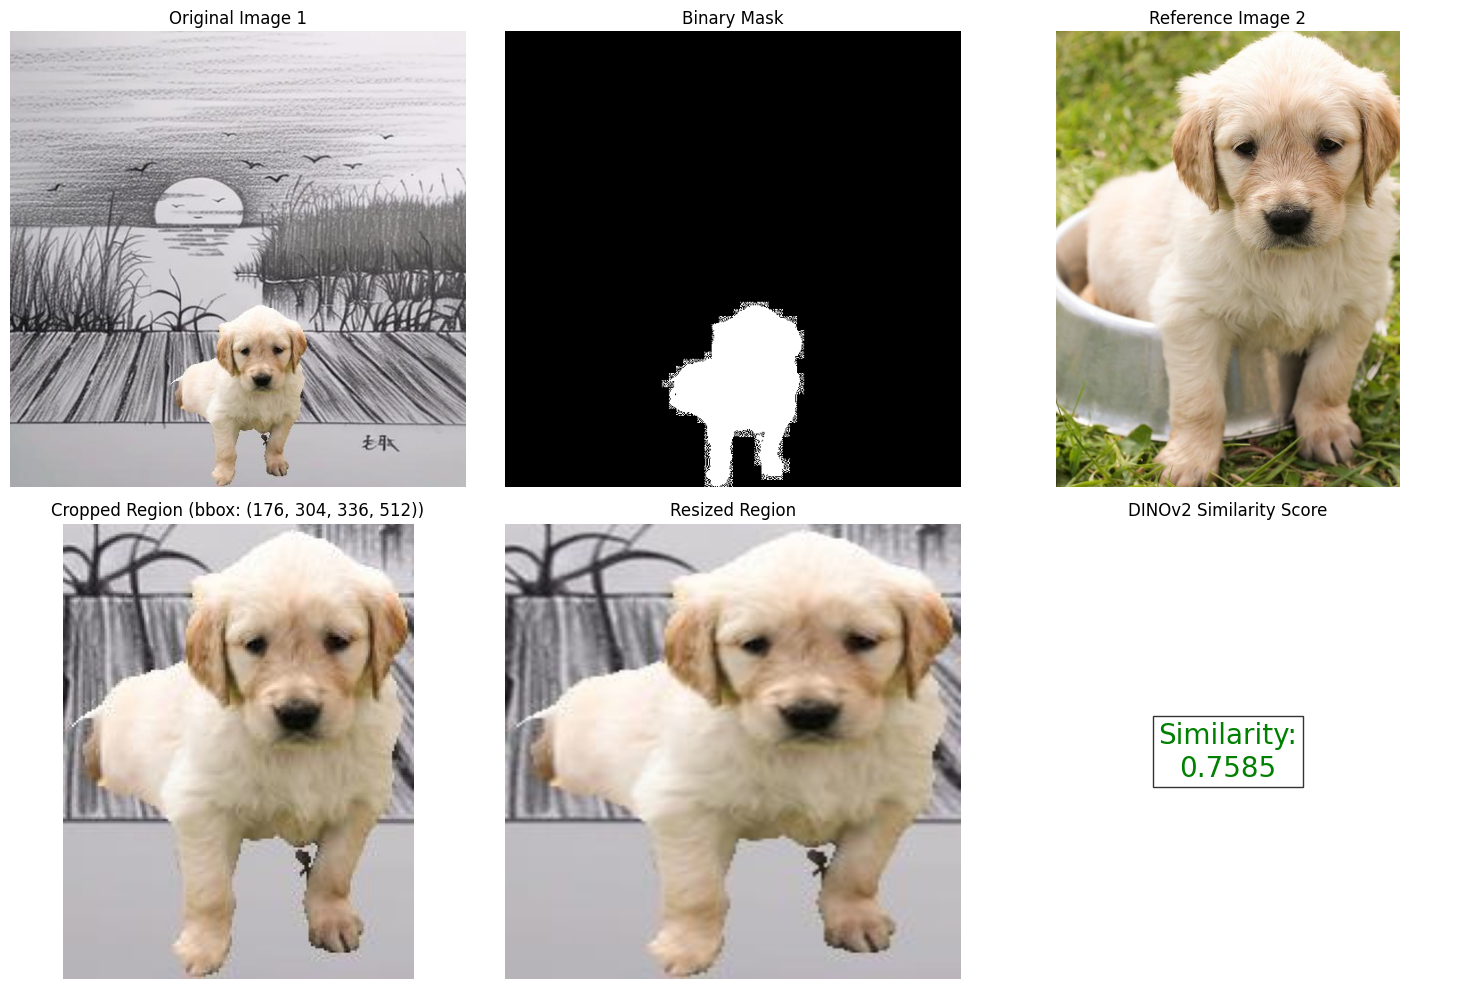

Computed similarity: 0.7585297226905823

Testing with a different example:
Category: Real-Sketch
Prompt: a pencil drawing of a dog in the sunset
Bounding box of masked region: (152, 312, 360, 512)


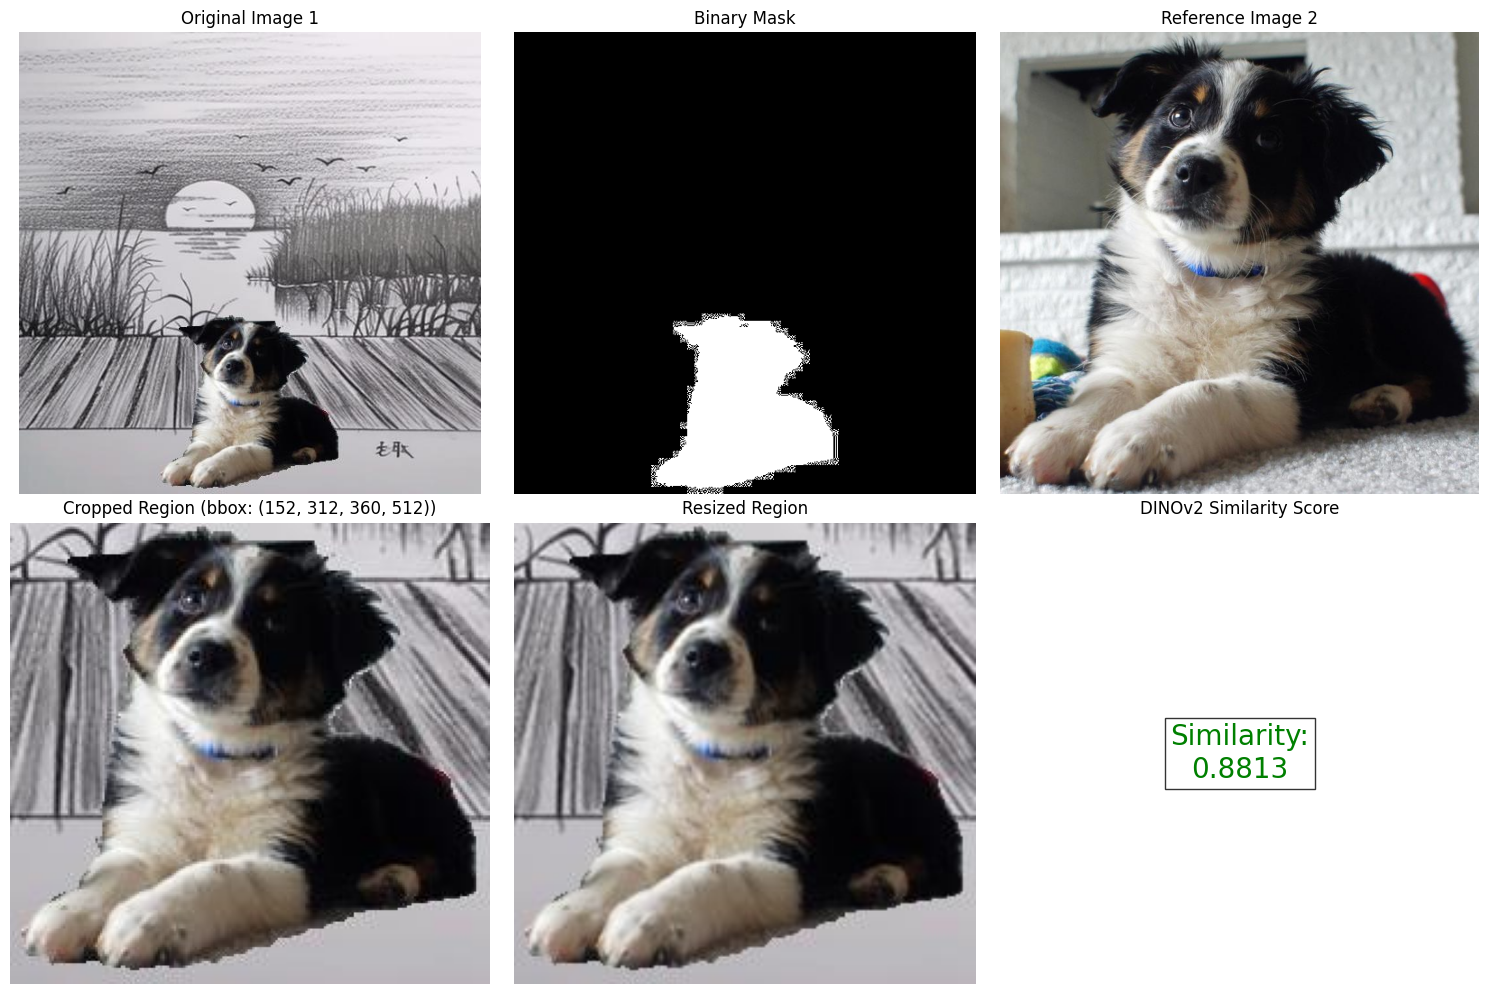

Computed similarity: 0.8813484907150269


In [6]:
from transformers import AutoImageProcessor, AutoModel
import torch
from PIL import Image

import torch.nn.functional as F
import matplotlib.pyplot as plt

# Import necessary libraries that are missing
import torchvision.transforms as T

# Create a function to visualize the intermediate steps
def visualize_dinov2_similarity(
    image1: Image.Image,
    image2: Image.Image,
    mask: Image.Image
) -> float:
    """
    Compute and visualize DINOv2 similarity computation between images
    """
    # Initialize model and processor if not already done
    if not hasattr(compute_dinov2_similarity, "model"):
        compute_dinov2_similarity.processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
        compute_dinov2_similarity.model = AutoModel.from_pretrained("facebook/dinov2-base")
        compute_dinov2_similarity.model.eval()

    processor = compute_dinov2_similarity.processor
    model = compute_dinov2_similarity.model
    
    # Ensure mask is same size as image1
    if mask.size != image1.size:
        print(f"Resizing mask from {mask.size} to match image1 size {image1.size}")
        mask = mask.resize(image1.size, resample=Image.NEAREST)

    # Convert mask to binary and get bounding box of masked region
    mask_binary = mask.convert("L").point(lambda p: p > 0 and 255)
    bbox = mask_binary.getbbox()
    if bbox is None:
        raise ValueError("Mask contains no non-zero region to compare.")
    
    print(f"Bounding box of masked region: {bbox}")
    
    # Crop the masked region and resize back to original size
    region = image1.crop(bbox)
    resized_region = region.resize(image1.size, resample=Image.BILINEAR)

    # Prepare images for model
    img1_rgb = resized_region.convert("RGB")
    img2_rgb = image2.convert("RGB")

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: Original images and mask
    axes[0, 0].imshow(image1)
    axes[0, 0].set_title("Original Image 1")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mask_binary, cmap='gray')
    axes[0, 1].set_title("Binary Mask")
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(image2)
    axes[0, 2].set_title("Reference Image 2")
    axes[0, 2].axis('off')
    
    # Row 2: Visualization of processing steps
    # Show the cropped region
    axes[1, 0].imshow(region)
    axes[1, 0].set_title(f"Cropped Region (bbox: {bbox})")
    axes[1, 0].axis('off')
    
    # Show the resized region
    axes[1, 1].imshow(resized_region)
    axes[1, 1].set_title("Resized Region")
    axes[1, 1].axis('off')
    
    # Compute similarity
    inputs = processor(images=[img1_rgb, img2_rgb], return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
        # Mean-pool token embeddings
        features = outputs.last_hidden_state.mean(dim=1)
        features = F.normalize(features, p=2, dim=-1)
        # Cosine similarity
        similarity = torch.matmul(features[0], features[1]).item()
    
    # Visualize similarity with color indicating strength
    sim_color = 'green' if similarity > 0.7 else 'orange' if similarity > 0.5 else 'red'
    axes[1, 2].text(0.5, 0.5, f"Similarity:\n{similarity:.4f}", 
                   horizontalalignment='center',
                   verticalalignment='center',
                   fontsize=20, color=sim_color,
                   bbox=dict(facecolor='white', alpha=0.8))
    axes[1, 2].set_title("DINOv2 Similarity Score")
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return similarity

# Test with the example
print(f"Example category: {example.category}")
print(f"Example prompt: {example.prompt}")
similarity = visualize_dinov2_similarity(example.result_image, example.fg_image, example.final_mask)
print(f"Computed similarity: {similarity}")

# Compare with a different example
if len(all_images) > 1:
    print("\nTesting with a different example:")
    different_example = all_images[1]
    print(f"Category: {different_example.category}")
    print(f"Prompt: {different_example.prompt}")
    similarity = visualize_dinov2_similarity(different_example.result_image, 
                                           different_example.fg_image, 
                                           different_example.final_mask)
    print(f"Computed similarity: {similarity}")

## Score all samples

In [ ]:
# download aesthetic predictor
!wget https://github.com/christophschuhmann/improved-aesthetic-predictor/raw/refs/heads/main/sac+logos+ava1-l14-linearMSE.pth 

In [6]:
from evaluation.eval import calculate_all_scores

all_images_list = []
for category in all_images:
    all_images_list.extend(all_images[category])

# Calculate scores for all benchmark images
df = calculate_all_scores(all_images_list, methods=['naive', "kv-edit", "tf-icon", "testing"], output_file="scores_testing.csv")

# Display the first few rows
df.head()

Processing 330 benchmark examples...


  0%|          | 0/330 [00:00<?, ?it/s]

Error processing image 67: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 68: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 69: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 84: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 144: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 145: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 146: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 147: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Scores saved to scores_testing.csv


image_index model_type      category  hpsv2_score  hpsv2_score_fg  \
0            0  Photoshop  Real-Cartoon     0.366406        0.367031   
1            0    TF-ICON  Real-Cartoon     0.429649        0.413644   
2            0    KV-EDIT  Real-Cartoon     0.399212        0.384817   
3            0    testing  Real-Cartoon     0.392956        0.375894   
4            1  Photoshop  Real-Cartoon     0.356176        0.369798   

   aesthetics_score  aesthetics_score_fg  background_mse  clip_text_image  \
0          5.149572             4.426442        0.000695         0.351008   
1          5.852400             4.880501        0.007479         0.349948   
2          5.848477             4.966319        0.000416         0.354293   
3          5.654108             5.001628        0.001793         0.347381   
4          5.103274             4.392820        0.000681         0.314153   

   clip_fg_image  dinov2_similarity     lpips  
0       0.664666           0.265576  0.865315  
1       0.666056           0.169509  0.870024  
2       0.678362           0.185860  0.873787  
3       0.660165           0.266646  0.866992  
4       0.638970           0.209002  0.916524